In [2]:
import pandas as pd
import numpy as np
import rebound
import matplotlib.pyplot as plt
from matplotlib import colors
from rebound.interruptible_pool import InterruptiblePool
import scipy.optimize as opt

In [3]:
from celmech.disturbing_function import df_coefficient_Ctilde
from celmech.disturbing_function import evaluate_df_coefficient_dict
from celmech.disturbing_function import laplace_b as b

In [5]:
def b1(alpha):
    return b(1.5, 1, 0, alpha)
def b2(alpha):
    return b(1.5, 2, 0, alpha)

In [6]:
def StoG(mass, amp, phi):
    m1, m3 = mass
    A1, A2, A3 = amp
    p1, p2, p3 = phi
    
    e1_x = 1/np.sqrt(m1)*(np.sqrt(m1/(m1+m3))*A1*np.cos(p1) - np.sqrt(m3/(m1+m3))*A2*np.cos(p2))
    e2_x = 1/np.sqrt(m1+m3)*A1*np.cos(p1) - A3*np.cos(p3)
    e3_x = 1/np.sqrt(m3)*(np.sqrt(m3/(m1+m3))*A1*np.cos(p1) + np.sqrt(m1/(m1+m3))*A2*np.cos(p2))
    
    e1_y = 1/np.sqrt(m1)*(np.sqrt(m1/(m1+m3))*A1*np.sin(p1) - np.sqrt(m3/(m1+m3))*A2*np.sin(p2))
    e2_y = 1/np.sqrt(m1+m3)*A1*np.sin(p1) - A3*np.sin(p3)
    e3_y = 1/np.sqrt(m3)*(np.sqrt(m3/(m1+m3))*A1*np.sin(p1) + np.sqrt(m1/(m1+m3))*A2*np.sin(p2))
    
    e1, e2, e3 = np.sqrt(e1_x**2 + e1_y**2), np.sqrt(e2_x**2 + e2_y**2), np.sqrt(e3_x**2 + e3_y**2)
    pom1, pom2, pom3 = np.arctan2(e1_y,e1_x), np.arctan2(e2_y,e2_x), np.arctan2(e3_y,e3_x)
    
    return (e1, e2, e3), (pom1, pom2, pom3)

In [7]:
def GtoS(alpha, mass, ecc, pomega):
    alpha12, alpha23 = alpha
    alpha13 = alpha12*alpha23
    m1, m3 = mass
    ecc1, ecc2, ecc3 = ecc
    pom1, pom2, pom3 = pomega

    e1_x, e2_x, e3_x = ecc1*np.cos(pom1), ecc2*np.cos(pom2), ecc3*np.cos(pom3)
    e1_y, e2_y, e3_y = ecc1*np.sin(pom1), ecc2*np.sin(pom2), ecc3*np.sin(pom3)
    
    amp1 = 1/np.sqrt(m1+m3) * np.sqrt((m1*e1_y + m3*e3_y)**2 + (m1*e1_x + m3*e3_x)**2)
    amp2 = np.sqrt(m1*m3/(m1+m3)) * np.sqrt((e3_y-e1_y)**2 + (e3_x-e1_x)**2)
    amp3 = 1/(m1+m3) * np.sqrt((m3*(e3_y-e2_y)-m1*(e2_y-e1_y))**2+(m3*(e3_x-e2_x)-m1*(e2_x-e1_x))**2)
    
    phase1 = np.arctan2(m1*e1_y+m3*e3_y, m1*e1_x+m3*e3_x)
    phase2 = np.arctan2(e3_y-e1_y, e3_x-e1_x)
    phase3 = np.arctan2(m3*(e3_y-e2_y)-m1*(e2_y-e1_y), m3*(e3_x-e2_x)-m1*(e2_x-e1_x))
    
    omega2 = (alpha12+alpha13+alpha23)/3 * (m1+m3)/(2*(1-alpha13)**2)
    omega3 = (alpha12+alpha13+alpha23)/3 * (m1/(2*(1-alpha12)**2) + m3/(2*(1-alpha23)**2))
    
    return amp1, amp2, amp3, phase1, phase2, phase3, omega2, omega3

In [8]:
def breathingON(mass, A3_p):
    m1, m3 = mass
    
    x1 = np.sqrt(m3/(m1*(m1+m3)))
    x2 = 1
    y1 = np.sqrt(m1/(m3*(m1+m3)))
    y2 = 1

    if m1==m3:
        A3_b = A3_p / np.sqrt(2)
        A2_b = A3_b*x2/x1
        theta = np.pi/2
    else:
        def A2(theta):
            return 2*A3_p*x2*y2*np.cos(theta) / np.sqrt((x1*y2-x2*y1)**2 + 4*x1*x2*y1*y2*(np.cos(theta))**2)
        def A3(theta):
            return A3_p*(x1*y2-x2*y1) / np.sqrt((x1*y2-x2*y1)**2 + 4*x1*x2*y1*y2*(np.cos(theta))**2)
        def e21_min(theta):
            return -(x1*A2(theta) + x2*A3(theta))**2
        def e32_min(theta):
            return -(y1*A2(theta) + y2*A3(theta))**2
        
        minimizer_kwargs = dict(method="L-BFGS-B", bounds=[(0,2*np.pi)])
        result21 = opt.basinhopping(e21_min, x0=0, minimizer_kwargs=minimizer_kwargs, niter=50)
        result32 = opt.basinhopping(e32_min, x0=0, minimizer_kwargs=minimizer_kwargs, niter=50)
        
        if np.fabs(result21.fun) > np.fabs(result32.fun):
            theta = result21.x
            A2_b, A3_b = A2(theta), A3(theta)
        else:
            theta = result32.x
            A2_b, A3_b = A2(theta), A3(theta)
    
    return A2_b, A3_b, theta

In [9]:
MASS = 3e-6, 3e-6
POMEGA = 0, 2*np.pi/3, -2*np.pi/3
f = 0.05
scale = 1e5

In [10]:
def simNoBreathing(alpha):
    alpha12, alpha23 = alpha
    P1, P2, P3 = alpha12**(3/2), 1, 1/alpha23**(3/2)
    mu1, mu3 = MASS
    ECC = f*(1-alpha12), f*(1-(alpha12+alpha23)/2), f*(1-alpha23)
    
    amp1, amp2, amp3, phase1, phase2, phase3, omega2, omega3,  = GtoS(alpha, MASS, ECC, POMEGA)
    ecc_nb, pomega_nb = StoG(MASS, (amp1, 0, amp3), (phase1, phase2, phase3))
    ecc1, ecc2, ecc3 = ecc_nb
    pomega1, pomega2, pomega3 = pomega_nb
    
    print(ecc_nb)
    print(pomega_nb)
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(P=P2, e=ecc2, pomega=pomega2)
    sim.add(m=mu3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    Nout=200
    e21, e32 = np.zeros(Nout), np.zeros(Nout)
    times = np.linspace(0,scale,Nout)
    
    for i, time in enumerate(times):
        try:
            sim.integrate(time)
            info_1 = sim.particles[1].calculate_orbit(primary=sim.particles[0])
            info_2 = sim.particles[2].calculate_orbit(primary=sim.particles[0])
            info_3 = sim.particles[3].calculate_orbit(primary=sim.particles[0])
            p1, p2, p3, e1, e2, e3 = info_1.pomega, info_2.pomega, info_3.pomega, info_1.e, info_2.e, info_3.e
            e1_x, e1_y = e1*np.cos(p1), e1*np.sin(p1)
            e2_x, e2_y = e2*np.cos(p2), e2*np.sin(p2)
            e3_x, e3_y = e3*np.cos(p3), e3*np.sin(p3)  
            
            e21[i] = np.sqrt((e2_x-e1_x)**2 + (e2_y-e1_y)**2)
            e32[i] = np.sqrt((e3_x-e2_x)**2 + (e3_y-e2_y)**2)
                       
        except rebound.Collision:
            break
    
    return e21, e32

In [11]:
def simWithBreathing(alpha):
    alpha12, alpha23 = alpha
    P1, P2, P3 = alpha12**(3/2), 1, 1/alpha23**(3/2)
    mu1, mu3 = MASS
    ECC = f*(1-alpha12), f*(1-(alpha12+alpha23)/2), f*(1-alpha23)
    
    amp1, amp2, amp3, phase1, phase2, phase3, omega2, omega3 = GtoS(alpha, MASS, ECC, POMEGA)   
    amp2_wb, amp3_wb, theta = breathingON(MASS, amp3)
    ecc_wb, pomega_wb = StoG(MASS, (amp1, amp2_wb, amp3_wb), (phase1, phase2, phase2+theta))
    
    ecc1, ecc2, ecc3 = ecc_wb
    pomega1, pomega2, pomega3 = pomega_wb
    
    print(ecc_wb)
    print(pomega_wb)
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(P=P2, e=ecc2, pomega=pomega2)
    sim.add(m=mu3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    Nout=200
    e21, e32 = np.zeros(Nout), np.zeros(Nout)
    times = np.linspace(0,scale,Nout)
    
    for i, time in enumerate(times):
        try:
            sim.integrate(time)
            info_1 = sim.particles[1].calculate_orbit(primary=sim.particles[0])
            info_2 = sim.particles[2].calculate_orbit(primary=sim.particles[0])
            info_3 = sim.particles[3].calculate_orbit(primary=sim.particles[0])
            p1, p2, p3, e1, e2, e3 = info_1.pomega, info_2.pomega, info_3.pomega, info_1.e, info_2.e, info_3.e
            e1_x, e1_y = e1*np.cos(p1), e1*np.sin(p1)
            e2_x, e2_y = e2*np.cos(p2), e2*np.sin(p2)
            e3_x, e3_y = e3*np.cos(p3), e3*np.sin(p3)  
            
            e21[i] = np.sqrt((e2_x-e1_x)**2 + (e2_y-e1_y)**2)
            e32[i] = np.sqrt((e3_x-e2_x)**2 + (e3_y-e2_y)**2)
                       
        except rebound.Collision:
            break
    
    return e21, e32

In [119]:
e12_nb, e23_nb = simNoBreathing((0.85, 0.85))
e12_wb, e23_wb = simWithBreathing((0.85, 0.85))

(0.003750000000000001, 0.0075, 0.003750000000000001)
(-1.0471975511965976, 2.0943951023931953, -1.0471975511965976)
(0.00879452954966893, 0.0042049512883486585, 0.00879452954966893)
(0.08308811259360027, 2.0943951023931953, -2.177483214986796)


Text(0.5, 0, 'time [$P_2$]')

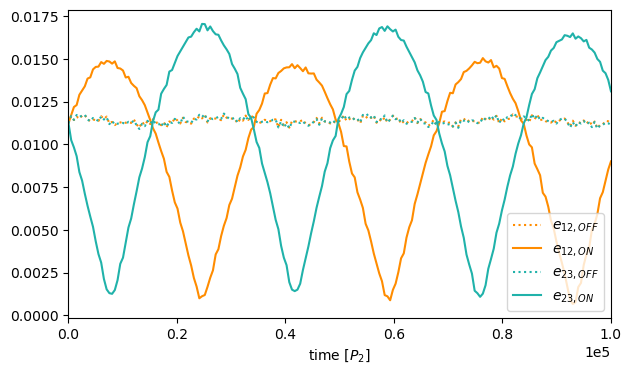

In [124]:
times = np.linspace(0,scale,200)

f, ax = plt.subplots(1, 1, figsize=(7,4))
ax.plot(times, e12_nb, color='darkorange', linestyle=':', label='$e_{12,OFF}$')
ax.plot(times, e12_wb, color='darkorange', linestyle='-', label='$e_{12,ON}$')
ax.plot(times, e23_nb, color='lightseagreen', linestyle=':', label='$e_{23,OFF}$')
ax.plot(times, e23_wb, color='lightseagreen', linestyle='-', label='$e_{23,ON}$')
ax.legend(loc="lower right", fontsize=10)
ax.set_xlim(0,scale)
ax.ticklabel_format(axis='x', style='sci', scilimits=(5,5))
ax.set_xlabel("time [$P_2$]")

In [12]:
def compare(results):
    count = 0
    for x in results:
        if x>1.98 and x<2.02:
            count += 1
    return count

1598
2792
1716


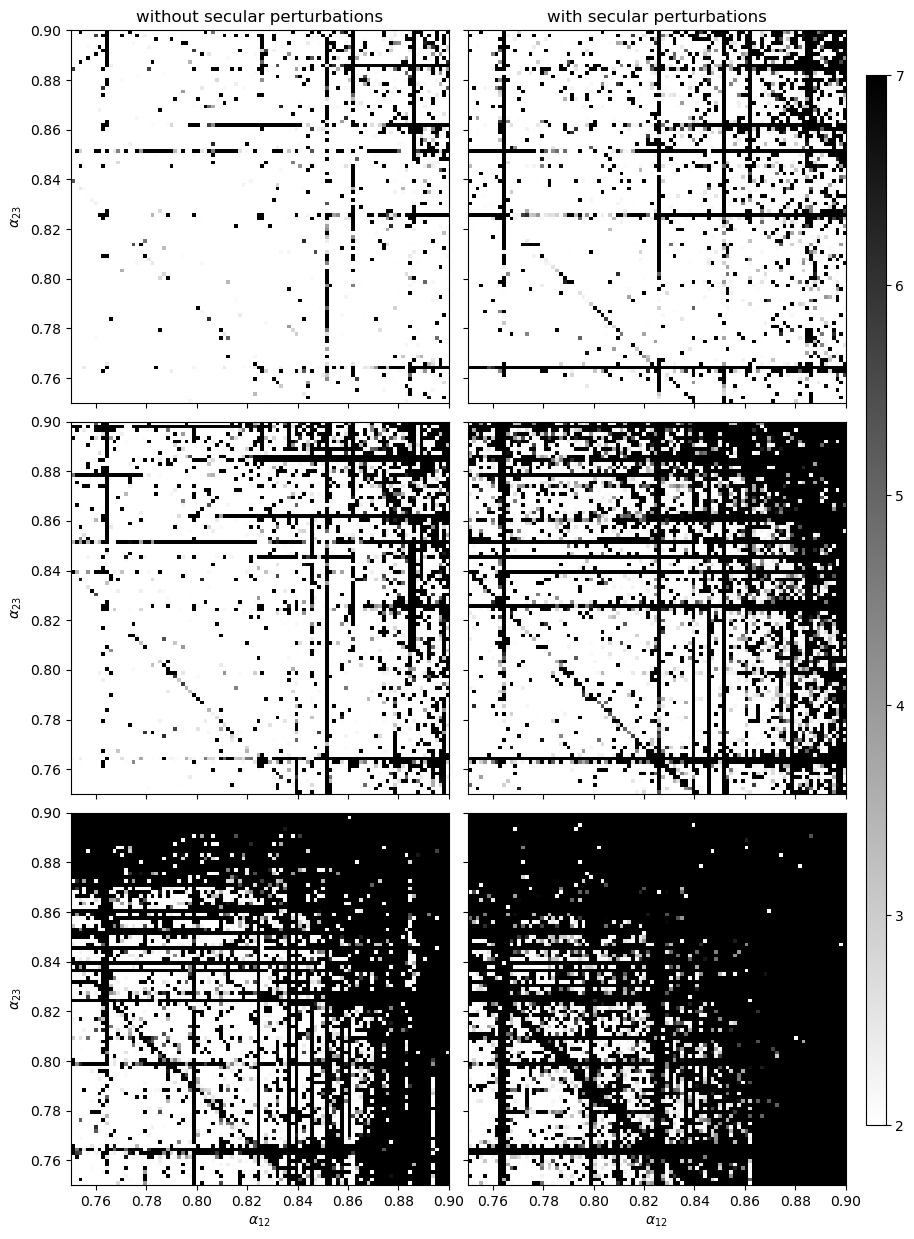

In [20]:
Ngrid_x = 100
Ngrid_y = 100

alpha12 = np.linspace(0.75,0.9,Ngrid_x)
alpha23 = np.linspace(0.75,0.9,Ngrid_y)
parameters = [[x,y] for x in alpha12 for y in alpha23]
df1 = pd.read_csv('MEGNO_nb_5%_ME.csv', header=None)
data_nb1 = df1.values.reshape(Ngrid_y,Ngrid_x)
df2 = pd.read_csv('MEGNO_wb_5%_ME.csv', header=None)
data_wb1 = df2.values.reshape(Ngrid_y,Ngrid_x)
df3 = pd.read_csv('MEGNO_nb_10%_ME.csv', header=None)
data_nb2 = df3.values.reshape(Ngrid_y,Ngrid_x)
df4 = pd.read_csv('MEGNO_wb_10%_ME.csv', header=None)
data_wb2 = df4.values.reshape(Ngrid_y,Ngrid_x)
df5 = pd.read_csv('MEGNO_nb_20%_ME.csv', header=None)
data_nb3 = df5.values.reshape(Ngrid_y,Ngrid_x)
df6 = pd.read_csv('MEGNO_wb_20%_ME.csv', header=None)
data_wb3 = df6.values.reshape(Ngrid_y,Ngrid_x)

print(compare(df1.values)-compare(df2.values))
print(compare(df3.values)- compare(df4.values))
print(compare(df5.values)- compare(df6.values))

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharey=True,sharex=True, figsize=(10,15))
f.subplots_adjust(hspace=0.05)
f.subplots_adjust(wspace=0.05)

extent = [min(alpha12),max(alpha12),min(alpha23),max(alpha23)]
ax1.set_xlim(extent[0],extent[1])
ax1.set_ylim(extent[2],extent[3])
ax1.set_ylabel(r"$\alpha_{23}$")
ax1.set_title("without secular perturbations")
# ax1.text(0.766,0.758,'$f=0.05$', horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='white', edgecolor='k', pad=2))

ax2.set_xlim(extent[0],extent[1])
ax2.set_ylim(extent[2],extent[3])
ax2.set_title("with secular perturbations")
# ax2.text(0.766,0.758,'$f=0.05$', horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='white', edgecolor='k', pad=2))

ax3.set_xlim(extent[0],extent[1])
ax3.set_ylim(extent[2],extent[3])
ax3.set_ylabel(r"$\alpha_{23}$")
# ax3.text(0.766,0.758,'$f=0.10$', horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='white', edgecolor='k', pad=2))

ax4.set_xlim(extent[0],extent[1])
ax4.set_ylim(extent[2],extent[3])
# ax4.text(0.766,0.758,'$f=0.10$', horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='white', edgecolor='k', pad=2))

ax5.set_xlim(extent[0],extent[1])
ax5.set_ylim(extent[2],extent[3])
ax5.set_ylabel(r"$\alpha_{23}$")
ax5.set_xlabel(r"$\alpha_{12}$")
# ax5.text(0.766,0.758,'$f=0.20$', horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='white', edgecolor='k', pad=2))


ax6.set_xlim(extent[0],extent[1])
ax6.set_ylim(extent[2],extent[3])
ax6.set_xlabel(r"$\alpha_{12}$")
# ax6.text(0.766,0.758,'$f=0.20$', horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='white', edgecolor='k', pad=2))

im1 = ax1.imshow(data_nb1.transpose(), vmin=2, vmax=7, interpolation="none", cmap="binary", origin="lower", aspect='auto', extent=extent)
im2 = ax2.imshow(data_wb1.transpose(), vmin=2, vmax=7, interpolation="none", cmap="binary", origin="lower", aspect='auto', extent=extent)
im3 = ax3.imshow(data_nb2.transpose(), vmin=2, vmax=7, interpolation="none", cmap="binary", origin="lower", aspect='auto', extent=extent)
im4 = ax4.imshow(data_wb2.transpose(), vmin=2, vmax=7, interpolation="none", cmap="binary", origin="lower", aspect='auto', extent=extent)
im4 = ax5.imshow(data_nb3.transpose(), vmin=2, vmax=7, interpolation="none", cmap="binary", origin="lower", aspect='auto', extent=extent)
im4 = ax6.imshow(data_wb3.transpose(), vmin=2, vmax=7, interpolation="none", cmap="binary", origin="lower", aspect='auto', extent=extent)


f.subplots_adjust(right=0.9)
cbar_ax = f.add_axes([0.92, 0.15, 0.02, 0.7])
f.colorbar(im1, cax=cbar_ax)

# im1 = ax1.imshow(data_nb.transpose(),vmin=2, vmax=8, cmap=colors.ListedColormap(['r','y','g','b','m','w']), origin="lower", aspect='auto', extent=extent)
# cb1 = plt.colorbar(im1, ax=ax1)
# im2 = ax2.imshow(data_wb.transpose(),vmin=2, vmax=8, cmap=colors.ListedColormap(['r','y','g','b','m','w']), origin="lower", aspect='auto', extent=extent)
# cb2 = plt.colorbar(im2, ax=ax2)
# cb2.set_label("collision time")

In [268]:
def rescale(data):
    data_scaled = np.zeros(len(data))
    for i,x in enumerate(data):
        log = -np.log10(np.fabs(x-2))
        if log > 0:
            data_scaled[i] = 0
        elif x == 4000:
            data_scaled[i] = -4
        elif log < -4:
            data_scaled[i] = -4
        else:
            data_scaled[i] = log
    return data_scaled

In [269]:
def plot(data1, data2, percent):
    x = np.linspace(0.75**(3/2),0.90**(3/2),len(count1))
    f, (ax1,ax2) = plt.subplots(2, 1, sharey=True, sharex=True, figsize=(9,4))
    f.subplots_adjust(hspace=0.2)

    ax1.scatter(x,data1,s=0.01,color="blue",alpha=0.5)
    ax2.scatter(x,data2,s=0.01,color="blue",alpha=0.5)
    ax1.vlines(np.array([2/3,3/4, 4/5, 5/6]), -4.2,0.2, linestyle='-',color='gray',linewidth=1)
    ax1.vlines(np.array([5/7, 7/9, 9/11, 11/13]),-4.2,0.2, linestyle=':',color='gray',linewidth=1)
    ax1.text(0.652,-3.6,f'$f={percent}$', horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='white', edgecolor='k', pad=2))
    ax1.set_ylim(-4.2,0.2)
    ax1.set_title("no secular perturbations")
    ax2.vlines(np.array([2/3,3/4, 4/5, 5/6]), -4.2,0.2, linestyle='-',color='gray',linewidth=1)
    ax2.vlines(np.array([5/7, 7/9, 9/11, 11/13]), -4.2,0.2, linestyle=':',color='gray',linewidth=1)
    ax2.set_ylim(-4.2,0.2)
    ax2.set_title("with secular perturbations")
    ax2.text(0.652,-3.6,f'$f={percent}$', horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='white', edgecolor='k', pad=2))
    ax2.set_xlabel(r"$\alpha$")

    f.text(0.06, 0.5, '$-\log_{10}$(MEGNO-2)', va='center', rotation='vertical')

In [270]:
df1 = pd.read_csv('DIAG_nb_5%_ME.csv', header=None)
count1 = rescale(df1.values)
df2 = pd.read_csv('DIAG_wb_5%_ME.csv', header=None)
count2 = rescale(df2.values)
df3 = pd.read_csv('DIAG_nb_10%_ME.csv', header=None)
count3 = rescale(df3.values)
df4 = pd.read_csv('DIAG_wb_10%_ME.csv', header=None)
count4 = rescale(df4.values)
df5 = pd.read_csv('DIAG_nb_20%_ME.csv', header=None)
count5 = rescale(df5.values)
df6 = pd.read_csv('DIAG_wb_20%_ME.csv', header=None)
count6 = rescale(df6.values)

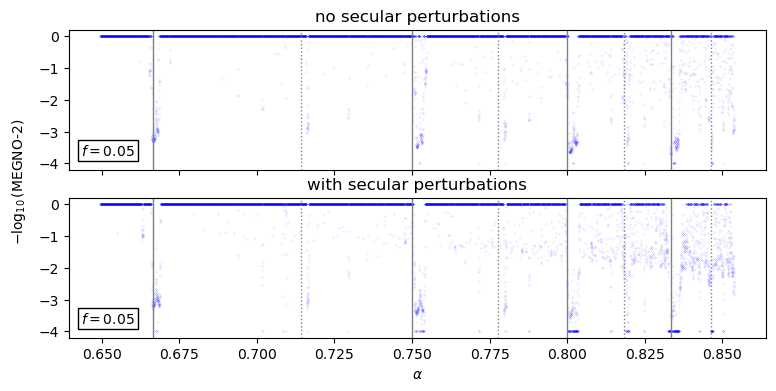

In [271]:
plot(count1, count2, 0.05)

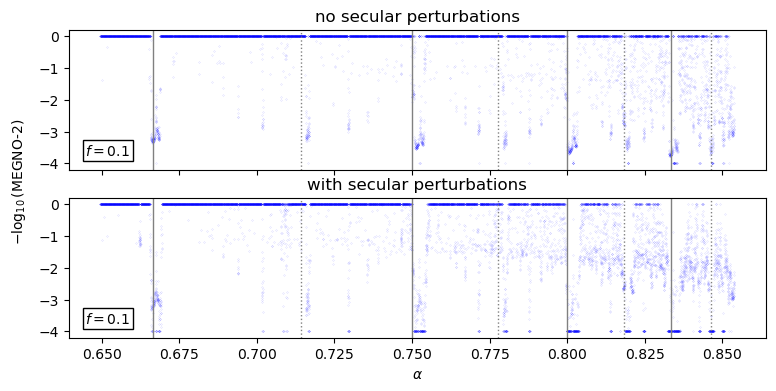

In [272]:
plot(count3, count4, 0.10)

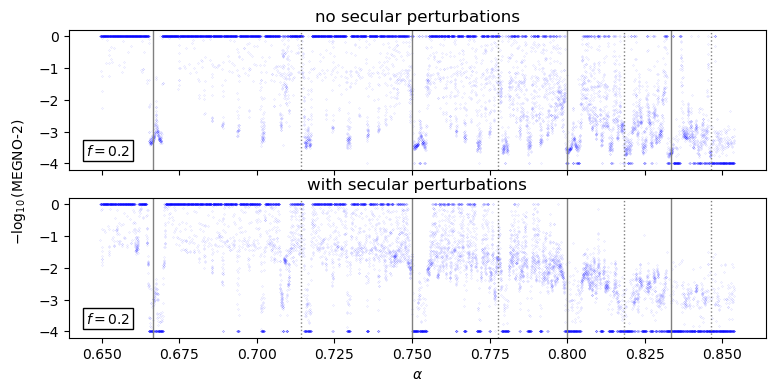

In [273]:
plot(count5, count6, 0.20)